## Comparing results of the CPU and GPU simulations.
To validate the GPU implementation, its results for a set of random protocols are checked against the reference data gathered by running the CPU simultion.

### Loading data

In [1]:
import numpy as np
import json

def read_results(filename, n, split=' '):
    results = []
    with open(filename) as file:
        for line in file:
            r = [float(n) for n in line.split(split)[:-1]]
            if not len(r) == n:
                print(len(results))
                continue
            results.append(np.array(r).reshape(10, -1))
    return results

res_cpu = read_results('results-cpu-random.txt', 480, split=', ')
res_gpu = read_results('results-gpu-random.txt', 1000)
N = np.shape(res_gpu)[0]

with open('1tumor-1protocol-results.json') as sd_file:
    single_data = json.load(sd_file)

### Checking normality of the results distribution

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import scipy
import scipy.stats as stats

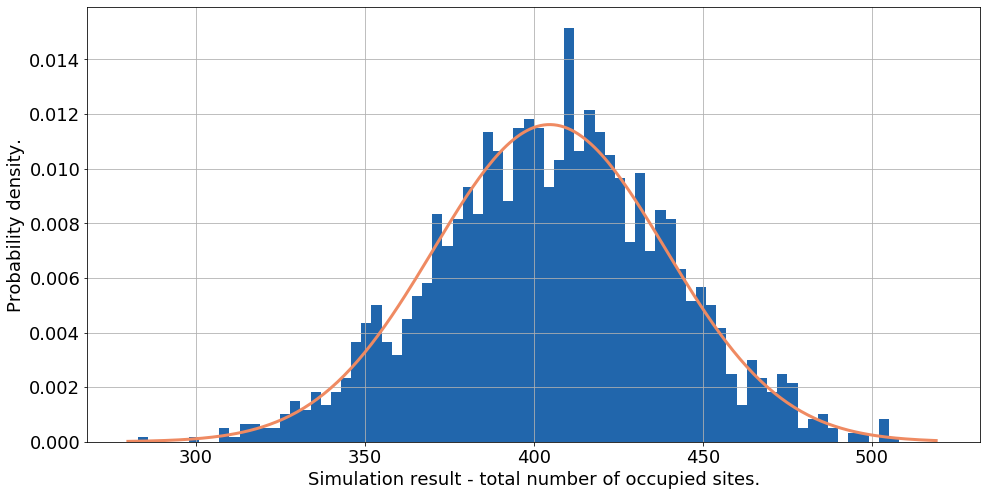

In [3]:
m = np.mean(single_data)
s = np.std(single_data)
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 8))
ax = fig.gca()
ax.set_ylabel("Probability density.")
ax.set_xlabel("Simulation result - total number of occupied sites.")
x = np.arange(280, 520, 1)
plt.plot(x, stats.norm.pdf(x, m, s), color='#ef8a62', linewidth=3)
plt.grid()
hist = plt.hist(single_data, range=(280, 520), bins=80, color='#2166ac', density=True)

### KS-test results

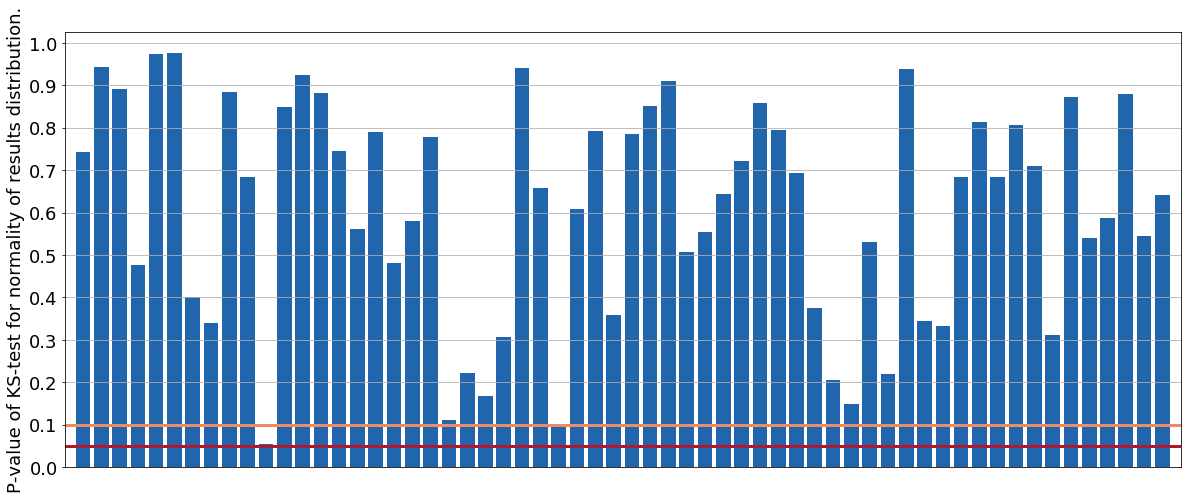

In [4]:
kstest_pvalues = [stats.kstest((res_gpu[i].reshape((-1)) - res_gpu[i].mean()) / res_gpu[i].std(), 'norm').pvalue for i in range(N)]

fig = plt.figure(figsize=(20, 8))
ax = fig.gca()
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("P-value of KS-test for normality of results distribution.")
ax.set_xticks([])
plt.xlim(-1, N)
plt.grid()
plt.bar(range(N), kstest_pvalues, color='#2166ac')
plt.plot([-1, N + .5], [0.05, 0.05], color='#b2182b', linewidth=3)
plt.plot([-1, N + .5], [0.1, 0.1], color='#ef8a62', linewidth=3)

### Comparing simulation results with t-test

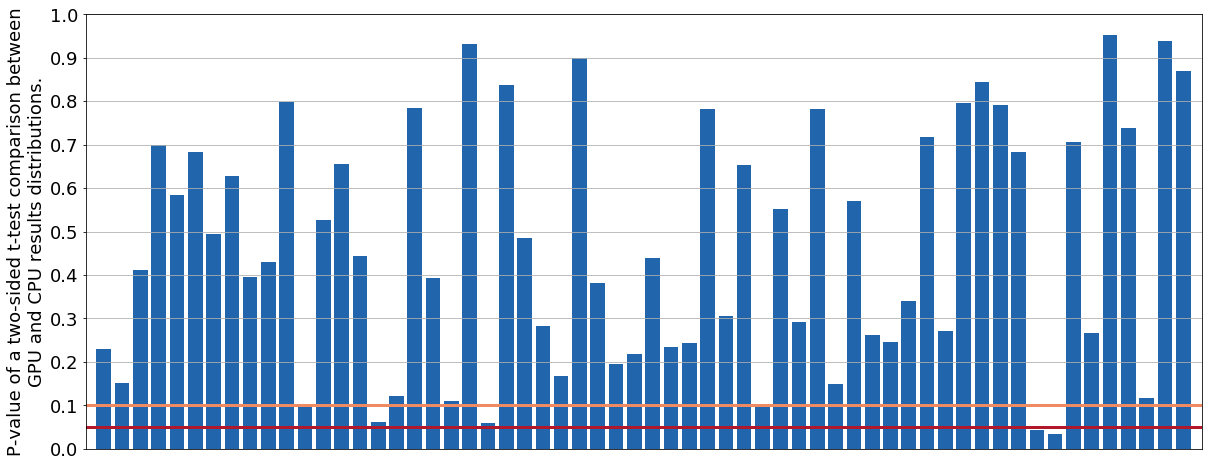

In [5]:
ttest_pvalues = [stats.ttest_ind(res_gpu[t].reshape((-1)), res_cpu[t].reshape((-1)), equal_var=False).pvalue for t in range(N)]

fig = plt.figure(figsize=(20, 8))
ax = fig.gca()
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("P-value of a two-sided t-test comparison between\nGPU and CPU results distributions.")
ax.set_xticks([])
plt.xlim(-1, N)
plt.grid()
plt.bar(range(N), ttest_pvalues, color='#2166ac')
plt.plot([-1, N + .5], [0.05, 0.05], color='#b2182b', linewidth=3)
plt.plot([-1, N + .5], [0.1, 0.1], color='#ef8a62', linewidth=3)

### Mean results plot

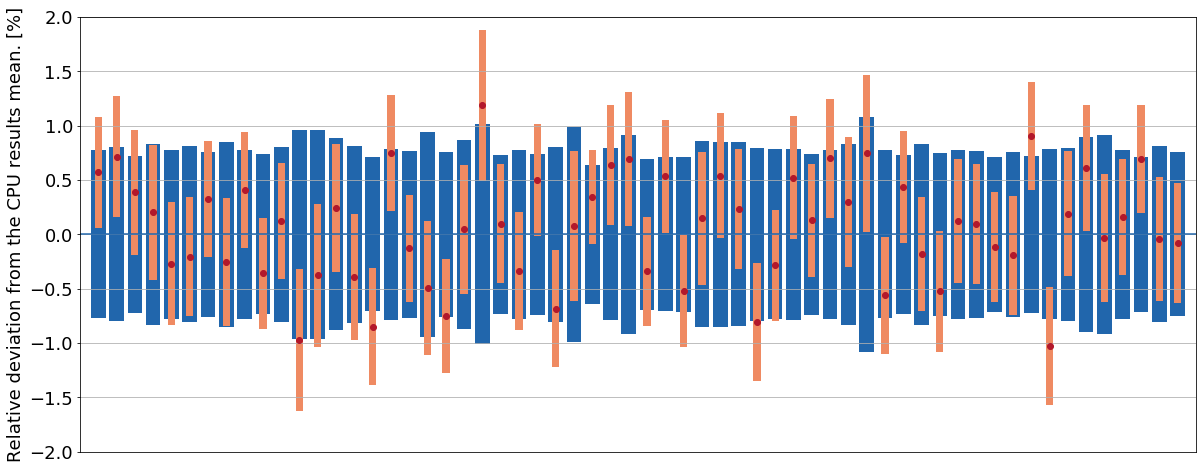

In [6]:
plt.rcParams.update({'font.size': 18})

CI = 0.95
cpu_intervals = [stats.norm.interval(CI, loc=res_cpu[t].mean(), scale=res_cpu[t].std()/np.sqrt(res_cpu[t].size)) for t in range(N)]
cpu_bottoms = [(cpu_intervals[t][0] - res_cpu[t].mean()) / res_cpu[t].mean() * 100 for t in range(N)]
cpu_heights = [(cpu_intervals[t][1] - cpu_intervals[t][0]) / res_cpu[t].mean() * 100 for t in range(N)]

gpu_intervals = [stats.norm.interval(CI, loc=res_gpu[t].mean(), scale=res_gpu[t].std()/np.sqrt(res_gpu[t].size)) for t in range(N)]
gpu_bottoms = [(gpu_intervals[t][0] - res_cpu[t].mean()) / res_cpu[t].mean() * 100 for t in range(N)]
gpu_heights = [(gpu_intervals[t][1] - gpu_intervals[t][0]) / res_cpu[t].mean() * 100 for t in range(N)]
gpu_mids = np.array(gpu_heights) / 2 + gpu_bottoms

fig = plt.figure(figsize=(20, 8))
ax = fig.gca()
ax.set_yticks(np.arange(-3, 3, 0.5))
ax.set_ylabel("Relative deviation from the CPU results mean. [%]")
ax.set_xticks([])
plt.grid()
plt.scatter(np.arange(0, N), gpu_mids, color='#b2182b', zorder=2)
plt.bar(np.arange(0, N), cpu_heights, 0.8, cpu_bottoms, color='#2166ac')
plt.bar(np.arange(0, N), gpu_heights, 0.4, gpu_bottoms, color='#ef8a62')
plt.plot([-3, N+3], [0, 0], color='#2166ac')
plt.xlim(-1, N)
plt.ylim(-2, 2)